In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext snakeviz

In [3]:
from typing import List, TYPE_CHECKING, Iterable, Dict

In [4]:
from evolution_rules import cpp_perfomance_by_doc, cpp_fitness_by_individual, cpp_fitness, cosine_similarity

# NER with Evolutionary Algorithms

In [5]:
from ga_ner.models import Vocabulary
enconding = 'iso-8859-1'
vocab = Vocabulary.from_iob('data/train/esp.train.txt', enconding, 10)

In [6]:
vocab.to_file('data/vocabs/conn-2002-uncased-vocab.txt')

## Evolutinary NER Rules

 - Take example of conll 2002 &check;
- Transform example to Doument object 
    - Create vocabulary from corpus text
    - Create vocabulary from corpus iob 
    - Create vocabulary from file &check;
    - Create vocabulary from spacy
    - Create vocabulary from conll2002 &check;
    - Create vocabulary from spacy after preprocessing
- Transform Document object to array &check;
- Create text documents to WORD POS DEPREL
    - Train neural network with word lemma pos deprel to predict next token
- Generate rules using genetic algorithm
    - Generate init population
        - Create chromosome
        - Select next token:
            - Get transition data
            - Filter samples evaluating their quality
    - Create fitness function
        - Evaluate fitness function
    - Create mutation function
        - Change token
        - Change transition
    - Create crossover function
        - Change token
        - Change transition
    - Evaluate population
        - Evaluate fitness
        - Select best samples
- Join rules
    - Support vector machine



1. Take a example of conll 2002
2. Create Ner rule with samples using genetic algorithm
3. Label data with rules
4. Train neural network with data labeled with rules
5. Select samples with high precision
1. repeat steps 2-5 with selected samples until precision is high enough

In [7]:
import numpy as np
from ga_ner.models import GANER, Document, Corpus, Vocabulary
import spacy

if TYPE_CHECKING:
    from spacy.tokens import Doc as SpacyDoc

### 1. Take a example of conll 2002

1. Load conll2002 to spacy documents
2. Load Vocabulary from conll2002
3. Take random samples from spacy documents
3. Convert Spacy models to Corpus object from samples


##### 1. Load conll2002 to spacy models

In [8]:
nlp = spacy.load("es_dep_news_trf",exclude=["ner"])

In [9]:
# Load spacy documents
from spacy.training.converters import conll_ner_to_docs
conll_file = 'data/train/esp.train.txt'
with open(conll_file, "r", encoding='iso-8859-1') as file:
    input_data = file.read()
docs = conll_ner_to_docs(input_data, n_sents=1, no_print=False, model="es_dep_news_trf")

In [10]:
# Simple load
spacy_ner_doc= list(docs)

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.


In [11]:
samples_len = len(spacy_ner_doc)
samples_len

8323

##### 2. Load Vocabulary from conll2002

In [12]:
vocabulary = Vocabulary.from_file(
    'data/vocabs/conn-2002-uncased-vocab.txt',
    include_special=False)

2784 = Vocab

62 = Dep

19 = POS

2703 = Word

##### 3. Take random samples from spacy documents

In [13]:
sample_is_complete_1 = np.zeros(samples_len, dtype=bool)

In [14]:
np.random.seed(0)
selected_indices_1 = np.random.choice(samples_len, size=266, replace=False)

##### 4. Convert Spacy models to Corpus object

In [15]:
def sample_spacy_docs(
    docs: List['SpacyDoc'],
    selected_indices: Iterable[int], 
    sample_is_complete: Iterable[int]) -> Iterable['SpacyDoc']:
    """
    Sample a list of spacy documents of selected index.
    If doc is not complete, it will be completed in spacy pipeline.
    """
    spacy_models = [docs[index] for index in selected_indices if not sample_is_complete[index]]

    # Complement spacy documents
    spacy_models =list(
        nlp.pipe(spacy_models, disable=["tok2vec", "tagger", "attribute_ruler"])
    )
        
    # Reassign spacy document
    index_doc = 0
    for index in selected_indices:
        if not sample_is_complete[index]:
            spacy_models[index_doc] = spacy_ner_doc[index]
            sample_is_complete[index] = True
            index_doc += 1
        yield docs[index]

In [17]:
corpus_1 = Corpus.from_spacy_docs(
    sample_spacy_docs(spacy_ner_doc, selected_indices_1, sample_is_complete_1),
    total_samples=len(selected_indices_1),
    vocab=vocabulary
)

  0%|          | 0/266 [00:00<?, ?it/s]

In [18]:
vocab_ent = Vocabulary.from_list(
    list(corpus_1.entities.keys()),include_special=False)

In [ ]:
corpus_1.documents[0].unk_id

2781

In [ ]:
corpus_1.to_text_array()

### 2. Create Ner rule with samples using genetic algorithm

1. From corpus create datasets by entities to predict
    - From datasets:
        - Convert to array
        - Get representation of documents for entities to predict
1. To Train Genetic Algorithm for entity
2. Get best genetic ner rules 


##### 1. From corpus create datasets by entities to predict

In [19]:
from tqdm.auto import tqdm, trange
entity_dataset: Dict[str,Dict[str, np.ndarray]] = {}
max_size_doc = 172
s_init_pop = 400
parent_population = np.zeros((s_init_pop, 10), dtype=np.float32)
parent_population[:,0] = 1
parent_population[:100,2] = 1
parent_population[100:200,2] = 2
parent_population[200:300,2] = 3
parent_population[300:400,2] = 4
parent_population[:,3] = corpus_1.documents[0].mask_id
index_pop = 0
import random
random.seed(42)

def add_to_dataset(
    input_ds:np.ndarray,
    target_ds:np.ndarray,
    meta_ds:np.ndarray, 
    document: Document,
    entity_label: str,
    index_pop:int
     )->bool:
    """
    Add a document to the dataset.
    If target document has not containt the entity, it won't be added.
    """
    if len(document.entities) == 0:
        return False, index_pop
    if entity_label == 'ALL':
        entity_label = None
    document_array = document.to_array(entity_label).reshape(-1, 4)
    max_size = min(max_size_doc, document_array.shape[0])
    meta_ds[:] = document_array[0]
    input_ds[:max_size-1] = document_array[1:max_size, :3]
    target_ds[:max_size-1] = document_array[1:max_size, 3:]
    return True, index_pop


for entity in tqdm(list(corpus_1.entities.keys()) + ['ALL']):
    entity_dataset[entity] = {}
    len_doc = len(corpus_1.documents)
    entity_dataset[entity]["input"] = np.zeros((len_doc, max_size_doc, 3), dtype=np.float32)
    entity_dataset[entity]["target"] = np.zeros((len_doc, max_size_doc, 1),dtype=np.int32)
    entity_dataset[entity]["meta"] = np.zeros((len_doc, 4),dtype=np.float32)
    
    # If document is not added then delete it from the dataset
    index_to_delete = []
    for index in trange(len_doc):
        
        is_added, index_pop = add_to_dataset(
            entity_dataset[entity]["input"][index],
            entity_dataset[entity]["target"][index],
            entity_dataset[entity]["meta"][index],
            corpus_1.documents[index],
            entity,
            index_pop
        )
        if not is_added:
            index_to_delete.append(index)
    # Delete samples without entity
    if len(index_to_delete) > 0:
        entity_dataset[entity]["input"] = np.delete(entity_dataset[entity]["input"], index_to_delete, axis=0)
        entity_dataset[entity]["target"] = np.delete(entity_dataset[entity]["target"], index_to_delete, axis=0)
        entity_dataset[entity]["meta"] = np.delete(entity_dataset[entity]["meta"], index_to_delete, axis=0)


for document in corpus_1.documents:
    # add entities to parent population
    for i, entity in enumerate(document.entities):
        size_entity = entity.end-entity.start
        entity_end =  size_entity+3
        document_array = document.to_array().reshape(-1, 4)
        entity_array = document_array[entity.start+2:entity.end+2]
        unique_index = np.unique(parent_population, axis=0, return_index=True)[1]
        entity_id = document.vocab_ent[entity.label]
        for j in range(3):
            if index_pop < s_init_pop:
                index_pop_temp = (entity_id-1) * 100 + index_pop%100
                parent_population[index_pop_temp][0] = min(size_entity,7)
                parent_population[index_pop_temp][2] = entity_id
                parent_population[index_pop_temp][3: entity_end] = document_array[entity.start+2:entity.end+2,j][:7]
                index_pop += 1
            elif unique_index.shape[0] < s_init_pop:
                # select random index to replace in parent population that is not in the population
                select_list = list(set(range((entity_id-1) * 100,entity_id-1* 100)) - set(unique_index))
                if select_list:
                    index_pop_temp = np.random.choice(select_list, 1)[0]
                    parent_population[index_pop_temp][0] = size_entity
                    parent_population[index_pop_temp][2] = entity_id
                    parent_population[index_pop_temp][3: entity_end] = document_array[entity.start+2:entity.end+2,j]
                    parent_population[index_pop_temp][entity_end:] = 0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

##### 2. To Train Genetic Algorithm for entity    

<p style="text-align: center;">Individual fitness</p>

$$f_i=\frac{TP_i}{TP_i+FP_i} * \log_2(TP_i+FP_i)$$


<p style="text-align: center;">Sharing function</p>

$$sh(d_{i,j}) = \left \{
    \begin{array}{l}
    1  - \frac{d_{i,j}}{\sigma_{share}}, d_{i,j} < {\sigma_{share}}  \\
    0, otherwise
    \end{array}
\right \}$$

<p style="text-align: center;">Individual shared fitness</p>

$$f^t_i = \frac{f_i}{\sum_{j=1}^N sh(d_{i,j})}$$


<div style="text-align: center;">

<p style="text-align: center;">Island model</p>

![image.png](./img/island_ae.svg)

</div>

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl
from ga_ner.ml.models import TransformerModel
from ga_ner.ml.loss import accuracy_loss


checkpoint_callback = ModelCheckpoint(
    './checkpoints_p', save_weights_only=True, monitor='val_loss',mode='min')

trainer = pl.Trainer(callbacks=[checkpoint_callback], enable_progress_bar=False)
model = TransformerModel.load_from_checkpoint("checkpoints/epoch=304-step=3050.ckpt")
trainer.model = model

/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
map_inv_entity = {corpus_1.vocab_ent[k]:k for k in corpus_1.entities.keys()}

In [ ]:
import cProfile as profile
import pstats
# Init GA Models
from ga_ner.models import GANER, Document, Corpus, Vocabulary, perfomance_by_doc
# from ga_ner.utils.numba import select
from evolution_rules import select

for i in [1,2,4,8,16]:
    filename = 'profile_stats_{}.stats'.format(i)
    ga_ner = GANER(
        data=entity_dataset,
        map_inv_entity=map_inv_entity,
        n_population=400,
        max_len=10,
        mask_id=corpus_1.documents[0].mask_id,
        unknown_id=corpus_1.documents[0].unk_id,
        ml_model=trainer,
        random_state=42,
        n_top=100,
        threshold=0.8,
        select=select,
        fitness=cpp_fitness,
        num_threads=i,
    )
    profile.run(f'ga_ner.train(max_iter=100, tol=10, base_population=parent_population, num_islands=4, num_threads={i})', filename)

/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import pstats
from pstats import SortKey

pstats_list: List[pstats.Stats] = []
for i in [1,2,4,8,16]:
    filename = 'profile_stats_{}.stats'.format(i)
    p = pstats.Stats(filename)
    p.sort_stats(SortKey.TIME).print_stats("fitness",10)
    pstats_list.append(p)

Tue Oct 18 22:56:36 2022    profile_stats_1.stats

         174064135 function calls (168243988 primitive calls) in 1108.509 seconds

   Ordered by: internal time
   List reduced from 1326 to 2 due to restriction <'fitness'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      571    4.343    0.008    4.343    0.008 {built-in method evolution_rules.cpp_fitness}
      571    0.013    0.000    4.357    0.008 /home/jraba/Dev/gar-lener-es/ga_ner/models.py:858(_fitness)


Tue Oct 18 23:12:52 2022    profile_stats_2.stats

         267467479 function calls (258522039 primitive calls) in 976.214 seconds

   Ordered by: internal time
   List reduced from 1020 to 2 due to restriction <'fitness'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      849    4.114    0.005    4.114    0.005 {built-in method evolution_rules.cpp_fitness}
      849    0.020    0.000    4.134    0.005 /home/jraba/Dev/gar-lener-es/ga_ner/models.py:858(_fitness)


Tue O

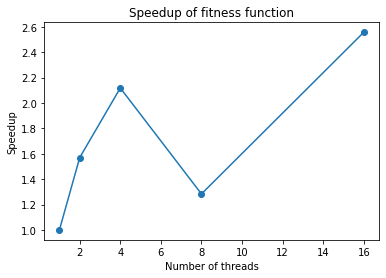

In [ ]:
# Plot speedup
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
y0 = 4.343/571
y = y0/np.array([4.343/571, 4.114/849, 3.016/840, 5.019/847, 2.507/843])
x = [1,2,4,8,16]
ax.plot(x, y, 'o-')
ax.set_xlabel('Number of threads')
ax.set_ylabel('Speedup')
ax.set_title('Speedup of fitness function')
plt.show()

In [ ]:
print(open('prun0', 'r').read())

         281893017 function calls (273658826 primitive calls) in 1101.951 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      400   93.506    0.234  145.894    0.365 models.py:1002(select)
   147435   87.594    0.001   87.594    0.001 {built-in method torch._C._nn.linear}
   447971   53.878    0.000   53.878    0.000 {method 'acquire' of '_thread.lock' objects}
37120444/34231489   52.490    0.000   83.899    0.000 {built-in method builtins.isinstance}
 36000000   51.435    0.000   51.435    0.000 numba.py:91(cosine_similarity)
  1558440   28.539    0.000   28.539    0.000 numba.py:35(perfomance_by_doc)
  2299395   19.308    0.000   51.096    0.000 module.py:1210(__setattr__)
  1149642   16.867    0.000   53.925    0.000 local.py:65(info)
12454730/12449055   16.698    0.000   17.273    0.000 {built-in method builtins.getattr}
  1532856   15.168    0.000   28.465    0.000 model_helpers.py:21(is_overridden)
    29487   14.48

In [ ]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary, perfomance_by_doc
# from ga_ner.utils.numba import select
from evolution_rules import select
ga_ner = GANER(
    data=entity_dataset,
    map_inv_entity=map_inv_entity,
    n_population=400,
    max_len=10,
    mask_id=corpus_1.documents[0].mask_id,
    unknown_id=corpus_1.documents[0].unk_id,
    ml_model=trainer,
    random_state=42,
    n_top=100,
    threshold=0.8,
    select=select,
    fitness=cpp_fitness,
    num_threads=16,
)
ga_ner.train(max_iter=1000, tol=10, base_population=parent_population, num_islands=4, num_threads=16)

In [ ]:
# Save entity names of ga_entities in file
with open("entity_names.txt", "w") as file:
    for entity in ga_ner.data.keys():
        file.write(entity)
        file.write("\n")

In [ ]:
for ent in ga_ner.data.keys():
    print(corpus_1.documents[0].vocab_ent[ent], ent)

1 PER
2 MISC
3 ORG
4 LOC
0 ALL


##### 3. Ner using genetic rules    

In [20]:
# Get list of features of population by entity type
# Use a document base to convert array to Feature using global index
from ga_ner.models import Feature, Rule, Document, Vocabulary
import numpy as np
from typing import List, Dict, Tuple, Iterable

In [21]:
entity_names = []
with open("entity_names.txt", "r") as file:
    for line in file:
        entity_names.append(line.strip())

In [22]:
vocabulary = Vocabulary.from_file(
    'data/vocabs/conn-2002-uncased-vocab.txt',
    include_special=False)

vocab_ent = Vocabulary.from_list(entity_names,include_special=False)

document = Document.from_text("", vocab=vocabulary, vocab_ent=vocab_ent)

In [23]:
from ga_ner.models import Feature, Rule, Document, Vocabulary

def get_features(
    ga_pupulation:np.ndarray,
    array_fitness:np.ndarray,
    document: Document,
    ) -> List[Rule]:
    """
    Decode Ga rules to Rule object.
    """
    rules = []
    for index in range(ga_pupulation.shape[0]):
        # firts element is the length of the rule
        end_rule = int(ga_pupulation[index, 0]) + 3
        entity_type = corpus_1.vocab_ent[ga_pupulation[index, 2]]
        rules.append(
            document.rule_from_array(
                ga_pupulation[index, 3:end_rule],
                int(ga_pupulation[index, 2]),
                array_fitness[index]
                ))
    return rules


In [24]:
# Read rules from file
rules = np.zeros((0, 10), dtype=np.float32)
with open("data/rules/mpi/population_8.txt", "r") as file:
    for line in file:
        rules = np.vstack((rules, np.array(line.strip().split(" ")).astype(np.float32)))
rules = np.unique(rules, axis=0)

In [25]:
vocab_ent.inverse()[1]

'PER'

In [26]:
fitness_ = cpp_fitness(
    rules,
    entity_dataset["ALL"]["input"],
    entity_dataset["ALL"]["target"][:,:,0],
    entity_dataset["ALL"]["meta"],
    corpus_1.documents[0].unk_id,
    8
).base

In [27]:
## Decode rules to Rule object
obj_rules = get_features(rules, np.zeros(rules.shape[0]), corpus_1.documents[0])# Count rules by entity type
from collections import Counter
counter_rule = Counter([rule.entity for rule in obj_rules])
print(counter_rule)
# get value the least common entity type
min_value = min(counter_rule.values())
print(min_value)

# Index of rules by entity type. Each can be at most min_value
index_rules = []
counter_balance = Counter()
for i in fitness_.argsort()[::-1]:
    if counter_balance[obj_rules[i].entity] < min_value:
        index_rules.append(i)
        counter_balance[obj_rules[i].entity] += 1


Counter({2: 194, 1: 192, 3: 105, 4: 95})
95


In [28]:
current_entity = 1
for i in index_rules:
    if obj_rules[i].entity == current_entity:
        print(obj_rules[i].to_dict(vocab=vocabulary, vocab_entities=vocab_ent))
        current_entity = (current_entity)% 4+1

{'label': 'PER', 'pattern': [{'POS': 'PROPN', 'is_entity': True}, {'DEP': 'flat', 'is_entity': True}]}
{'label': 'MISC', 'pattern': [{'POS': 'PROPN', 'is_entity': True}]}
{'label': 'ORG', 'pattern': [{'POS': 'PROPN', 'is_entity': True}, {'POS': 'ADP', 'is_entity': True}, {'POS': 'PROPN', 'is_entity': True}, {'POS': 'PUNCT', 'is_entity': False}]}
{'label': 'LOC', 'pattern': [{'DEP': 'nmod', 'is_entity': True}]}
{'label': 'PER', 'pattern': [{'DEP': 'punct', 'is_entity': True}, {'POS': 'PROPN', 'is_entity': True}, {'POS': 'PROPN', 'is_entity': True}, {'POS': 'PROPN', 'is_entity': True}, {'DEP': 'punct', 'is_entity': False}]}
{'label': 'MISC', 'pattern': [{'POS': 'PROPN', 'is_entity': True}, {'POS': 'PROPN', 'is_entity': False}, {'DEP': 'flat', 'is_entity': True}]}
{'label': 'ORG', 'pattern': [{'POS': 'PROPN', 'is_entity': True}, {'POS': 'ADP', 'is_entity': True}, {'POS': 'PROPN', 'is_entity': True}, {'POS': 'PUNCT', 'is_entity': False}, {'POS': 'PROPN', 'is_entity': True}]}
{'label': 'LOC

In [29]:
from spacy.training.converters import conll_ner_to_docs
conll_file = 'data/test/esp.testa.txt'
with open(conll_file, "r", encoding='iso-8859-1') as file:
    input_data = file.read()
docs_val = conll_ner_to_docs(input_data, n_sents=1, no_print=False, model="es_dep_news_trf")
# Simple load
spacy_ner_doc_val= list(docs_val)
samples_len = len(spacy_ner_doc_val)

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.


In [30]:
sample_is_complete_val = np.zeros(samples_len, dtype=bool)
np.random.seed(0)
selected_indices_val = np.random.choice(samples_len, size=1000, replace=False)

In [31]:
corpus_val = Corpus.from_spacy_docs(
    sample_spacy_docs(spacy_ner_doc_val, selected_indices_val, sample_is_complete_val),
    total_samples=len(selected_indices_val),
    vocab=vocabulary,
    vocab_ent=vocab_ent,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
entity_map=np.array(["O"]+entity_names)

##### Predict entities with ner rules

In [33]:
from typing import List, Dict, Tuple, Iterable

def slice_doc(
    doc: np.ndarray, rule: np.ndarray, unknown_id: int
    ) -> Iterable[Tuple[int, int]]:
        """Return indices where entity is located in the document.
        """
        rule_size: int = int(rule[0])
        individual_data = rule[3:3+rule_size].reshape(-1, 1)
        entity_mask: np.ndarray = individual_data > 0
        mask_unknown: np.ndarray = individual_data == unknown_id

        for index in range(0, doc[0] - rule_size + 2):
            index_doc = index + 1
            macth_tokens = np.zeros(rule_size, dtype=bool)
            is_match = True
            for index_rule in range(rule_size):
                index_token = (index_doc+index_rule)*3
                if is_match:
                    if ((
                        doc[index_token:index_token+3] == np.abs(individual_data[index_rule])).any() 
                        | (mask_unknown[index_rule])):
                        macth_tokens[index_rule] = True
                else:
                    is_match = False
            
            if macth_tokens.all():
                if rule_size == 1:
                    yield index_doc, index_doc + 1
                else:
                    start_index = index_doc
                    end_index = index_doc + 1
                    for index_include in range(rule_size-1):
                        if index_include == rule_size - 2 and individual_data[index_include + 1] > 0:
                            end_index = index_doc + index_include + 2
                            if not individual_data[index_include] > 0:
                                start_index = index_doc + index_include+1
                            yield start_index, end_index
                        elif not individual_data[index_include] > 0:
                            start_index = index_doc + index_include + 1
                        elif not individual_data[index_include + 1] > 0:
                            end_index = index_doc + index_include + 1
                            yield start_index, end_index
                            start_index = index_doc + index_include + 1
                        elif index_include == rule_size - 2:
                            end_index = index_doc + index_include + 2
                            yield start_index, end_index
                        else:
                            end_index = index_doc + index_include + 1

In [34]:
# plot confusion matrix normalized
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def print_cm(target, predict, labels, normalize=True):
    cm = confusion_matrix(target, predict, labels=labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = labels,
                      columns = labels)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues")

In [35]:
# Train a model with the best rules
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC

# Train partial model with each document
classifier = LinearSVC(
    random_state=42,
    class_weight="balanced",
    # class_weight={
    #     0:0.00952557,
    #     1:0.25158227,
    #     2:0.35653684,
    #     3:0.17772326,
    #     4:0.20463206},
    tol=1e-3
   )

# classifier = SGDClassifier(
#     loss="hinge",
#     random_state=42,
#     class_weight="balanced",
#     tol=1e-3,
#    )

  0%|          | 0/266 [00:00<?, ?it/s]

/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

         LOC       0.65      0.76      0.70       284
        MISC       0.62      0.40      0.49       163
           O       0.99      0.99      0.99      6101
         ORG       0.72      0.60      0.66       327
         PER       0.68      0.80      0.74       231

    accuracy                           0.95      7106
   macro avg       0.73      0.71      0.72      7106
weighted avg       0.95      0.95      0.95      7106



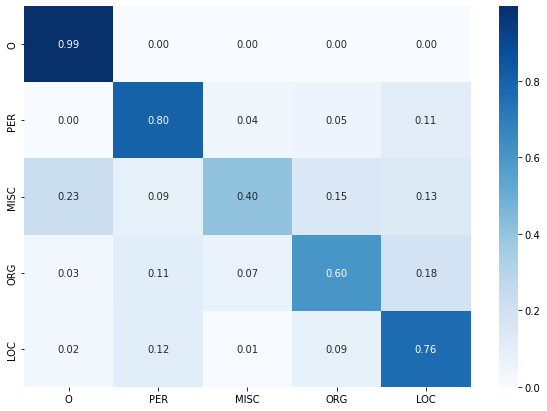

In [36]:
from tqdm.auto import tqdm
target = []
predict = []

input_data_all = np.array([])
target_data_all = np.array([], dtype=int)
votes_all = np.array([], dtype=int)

for index_doc, doc in enumerate(tqdm(corpus_1.documents)):
    if len(doc.entities) == 0:
        continue
    
    # index_rule = fitness_.argsort()[::-1][:400]
    # index_rule = list(range(400))
    array_rules = rules[index_rules]
    array_fitness = fitness_[index_rules]
    # log2_rules = np.log10(array_rules[:, 0])
    array_doc = doc.to_array(exclude_label=True)
    input_data = np.zeros((array_doc[0], len(array_rules)), dtype=float)
    target_data = np.zeros(array_doc[0], dtype=int)
    unk_id = doc.unk_id
    # get rules for each entity
    index_data = 0
    target_data[:] = doc.to_entity_array()[2:-1]
    target.extend(entity_map[doc.to_entity_array()[2:-1]].tolist())
    #index_rules = np.argsort(np.load(f"best_fitness.npy"))[::-1]
    #array_rules = np.load(f"best_population.npy")[index_rules][:200]
    #array_fitness = np.load(f"best_fitness.npy")[index_rules][:200]
    # get votes from rules 
    votes = np.zeros((array_doc[0], 5), dtype=float)
    for index_rule in range(array_rules.shape[0]):
        slices = slice_doc(array_doc, array_rules[index_rule], unk_id)
        for start, end in slices:
            # input_data[start:end, index_data] = array_fitness[index_rule]
            entity_id = array_rules[index_rule, 2]
            input_data[start-2:end-2, index_data] = entity_id # +log2_rules[index_rule]
            votes[start-2:end-2, int(entity_id)] = votes[start-2:end-2, int(entity_id)] + array_fitness[index_rule]
            
        index_data += 1
    
    # extend input data all with input data
    input_data_all = np.vstack((input_data_all, input_data)) if input_data_all.size else input_data
    target_data_all = np.concatenate((target_data_all, target_data))
    votes_all = np.vstack((votes_all, votes)) if votes_all.size else votes

classifier.fit(input_data_all, target_data_all)
predict.extend(entity_map[classifier.predict(input_data_all)].tolist())
print(classification_report(target, predict))
print_cm(target, predict, entity_map)

In [37]:
# add tagger to the pipeline to spacy_ner_doc
nlp2 = spacy.load("es_core_news_md", disable=["ner"])

In [38]:
index = 0
doc_spa = nlp2(str(spacy_ner_doc[index]))
doc_spa.ents = spacy_ner_doc[index].ents
doc_spa

Melbourne ( Australia ) , 25 may ( EFE ) . 

In [39]:
target = []
array_rules = rules[index_rules]
array_fitness = fitness_[index_rules]
#doc = corpus_1.documents[1]
doc = Document.from_spacy_document(doc_spa, vocabulary, vocab_ent)
array_doc = doc.to_array(exclude_label=True)
input_data = np.zeros((array_doc[0], len(array_rules)), dtype=float)
target_data = np.zeros(array_doc[0], dtype=int)
unk_id = doc.unk_id
# get rules for each entity
index_data = 0
target_data[:] = doc.to_entity_array()[2:-1]
target.extend(entity_map[doc.to_entity_array()[2:-1]].tolist())
# target_tensor[index_doc, array_doc[0]] = tag_to_ix[STOP_TAG]

#index_rules = np.argsort(np.load(f"best_fitness.npy"))[::-1]
#array_rules = np.load(f"best_population.npy")[index_rules][:200]
#array_fitness = np.load(f"best_fitness.npy")[index_rules][:200]
# get votes from rules 
votes = np.zeros((array_doc[0], 5), dtype=float)
for index_rule in range(array_rules.shape[0]):
    slices = slice_doc(array_doc, array_rules[index_rule], unk_id)
    for start, end in slices:
        # input_data[start:end, index_data] = array_fitness[index_rule]
        entity_id = array_rules[index_rule, 2]
        input_data[start-2:end-2, index_data] = entity_id # +log2_rules[index_rule]
        votes[start-2:end-2, int(entity_id)] = votes[start-2:end-2, int(entity_id)] + array_fitness[index_rule]
        # votes[start-2:end-2, int(entity_id)] = votes[start-2:end-2, int(entity_id)] + 1
        
    index_data += 1

In [40]:
votes[:,0] = (votes[:,1:].sum(axis=1)/2)
votes[:,0] = np.where(votes[:,0] > 0.5, votes[:,0], 0.5)
predicted_entities = entity_map[votes.argmax(axis=1)].tolist()
print(predicted_entities)
print(target)

['LOC', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O']
['LOC', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O']


In [41]:
spacy.displacy.render(
    doc_spa, style="ent", jupyter=True, options={"distance": 100})

In [42]:
# Define start and end each entity predicted
ex = [
    {"text": str(doc_spa), "ents": [], "title": None},
]

prev_entity = predicted_entities[0]
start = 0
end = 0
for index, entity in enumerate(predicted_entities):
    if entity != prev_entity:
        if prev_entity != "O":
            span = doc_spa[start:end+1]
            ex[0]["ents"].append({"start": span.start_char, "end": span.end_char, "label": prev_entity})
        start = index
        prev_entity = entity
    end = index
if entity == prev_entity and prev_entity != "O":
    span = doc_spa[start:end+1]
    ex[0]["ents"].append({"start": span.start_char, "end": span.end_char, "label": prev_entity})


        
# Render the entities
spacy.displacy.render(ex, style="ent", manual=True, jupyter=True)


In [43]:
        
# Define start and end each entity predicted
ex = [
    {"text": str(doc_spa), "ents": [], "title": None},
]
predicted_entities = entity_map[classifier.predict(input_data)].tolist()
prev_entity = predicted_entities[0]
start = 0
end = 0
for index, entity in enumerate(predicted_entities):
    if entity != prev_entity:
        if prev_entity != "O":
            span = doc_spa[start:end+1]
            ex[0]["ents"].append({"start": span.start_char, "end": span.end_char, "label": prev_entity})
        start = index
        prev_entity = entity
    end = index
if entity == prev_entity and prev_entity != "O":
    span = doc_spa[start:end+1]
    ex[0]["ents"].append({"start": span.start_char, "end": span.end_char, "label": prev_entity})


        
# Render the entities
spacy.displacy.render(ex, style="ent", manual=True, jupyter=True)


In [43]:
from pathlib import Path
spacy.displacy.render(
    doc_spa, style="dep", jupyter=True, options={"distance": 100})

svg = spacy.displacy.render(
    doc_spa, style="dep", jupyter=False, options={"distance": 120})
output_path = Path("./docs/img/sentence.svg")
output_path.open("w", encoding="utf-8").write(svg)

3887

In [44]:
# Predict with majority vote using the best rules
predict = []
votes_all[:,0] = (votes_all[:,1:].sum(axis=1)/2)
votes_all[:,0] = np.where(votes_all[:,0] > 0.5, votes_all[:,0], 0.5)
predict=entity_map[votes_all.argmax(axis=1)].tolist()
len(predict)

7106

              precision    recall  f1-score   support

         LOC       0.50      0.55      0.52       284
        MISC       0.71      0.06      0.11       163
           O       0.95      0.98      0.97      6101
         ORG       0.52      0.26      0.35       327
         PER       0.44      0.56      0.49       231

    accuracy                           0.90      7106
   macro avg       0.62      0.48      0.49      7106
weighted avg       0.89      0.90      0.89      7106



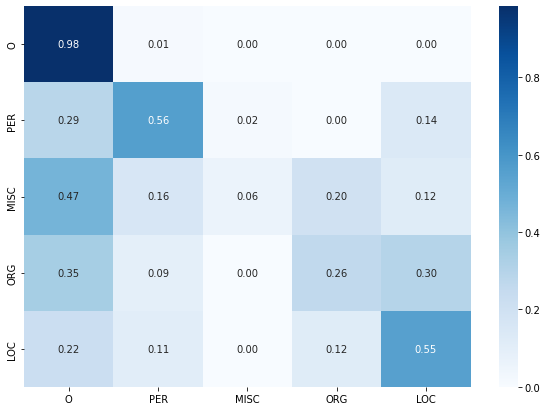

In [45]:
print(classification_report(entity_map[target_data_all], predict))
print_cm(entity_map[target_data_all], predict, entity_map)

  0%|          | 0/266 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         LOC       0.29      0.47      0.36       171
        MISC       0.20      0.11      0.14       160
           O       0.99      0.99      0.99      5319
         ORG       0.55      0.44      0.49       329
         PER       0.52      0.57      0.54       262

    accuracy                           0.91      6241
   macro avg       0.51      0.52      0.50      6241
weighted avg       0.91      0.91      0.91      6241



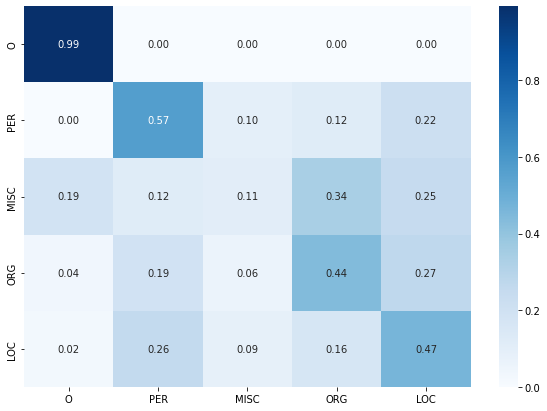

In [46]:
target = []
predict = []
votes_all_val = np.array([], dtype=float)

for doc in tqdm(corpus_val.documents[:266]):
    if len(doc.entities) == 0:
        continue

    # index_rule = fitness_.argsort()[::-1][:400]
    array_rules = rules[index_rules]
    array_doc = doc.to_array(exclude_label=True)
    input_data = np.zeros((array_doc[0], len(array_rules)), dtype=float)
    target_data = np.zeros(array_doc[0], dtype=float)
    unk_id = doc.unk_id
    # get rules for each entity
    index_data = 0
    target_data[:] = doc.to_entity_array()[2:-1]
    target.extend(entity_map[doc.to_entity_array()[2:-1]].tolist())

    # for entity_index, entity in enumerate(entity_names, 1):
    # array_rules = np.load(f"best_population.npy")
    # array_fitness = np.load(f"best_fitness.npy")
    
    # get votes from rules
    votes = np.zeros((array_doc[0], 5), dtype=float)
    for index_rule in range(array_rules.shape[0]):
        slices = slice_doc(array_doc, array_rules[index_rule], unk_id)
        # log2_rules = np.log10(array_rules[:, 0])
        for start, end in slices:
            entity_id = array_rules[index_rule, 2]
            input_data[start-2:end-2, index_data] = entity_id
            #input_data[start:end, index_data] = array_rules[index_rule, 2]# +log2_rules[index_rule]
            votes[start-2:end-2, int(array_rules[index_rule, 2])] = votes[start-2:end-2, int(array_rules[index_rule, 2])] + array_fitness[index_rule]
        index_data += 1
    
    # extend input data all with input data
    votes_all_val = np.vstack((votes_all_val, votes)) if votes_all_val.size else votes
    predict.extend(entity_map[classifier.predict(input_data)].tolist())

print(classification_report(target, predict))
print_cm(target, predict, entity_map)

              precision    recall  f1-score   support

         LOC       0.11      0.53      0.18       171
        MISC       0.13      0.03      0.04       160
           O       0.99      0.89      0.94      5319
         ORG       0.41      0.23      0.29       329
         PER       0.39      0.62      0.48       262

    accuracy                           0.81      6241
   macro avg       0.41      0.46      0.39      6241
weighted avg       0.89      0.81      0.84      6241



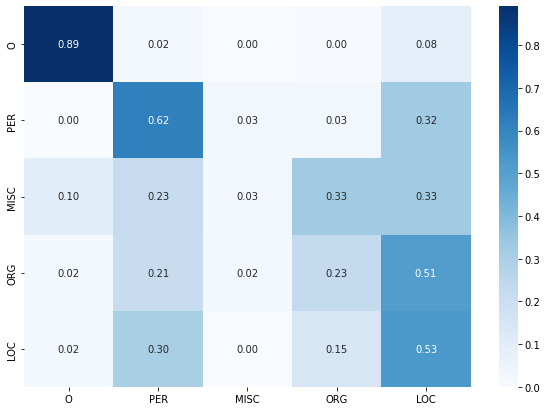

In [47]:
predict = []
votes_all[:,0] = (votes_all[:,1:].sum(axis=1)/2)
votes_all[:,0] = np.where(votes_all[:,0] > 0.5, votes_all[:,0], 0.5)
predict = entity_map[votes_all_val.argmax(axis=1)].tolist()
print(classification_report(target, predict))
print_cm(target, predict, entity_map)

[(1, 1.0), (2, 1.9151450447623743), (3, 2.5060519776903307), (4, 3.7249354066606433), (5, 4.586968827467744), (6, 4.965085200562017), (8, 5.670728764478765)]


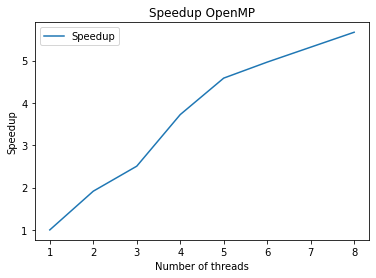

[(1, 1.0), (2, 0.9575725223811872), (3, 0.8353506592301102), (4, 0.9312338516651608), (5, 0.9173937654935488), (6, 0.8275142000936695), (8, 0.7088410955598456)]


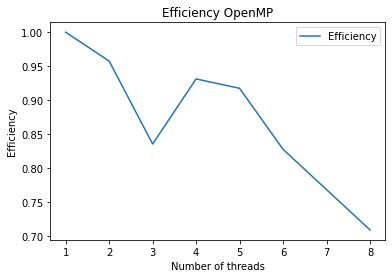

In [49]:
# Plot speedup openmp from file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_opemmp= pd.read_csv("data/rules/openmp/time.txt", sep=",", header=None)
df_opemmp.columns = ["Num threads", "time"]
df_opemmp["speedup"] = df_opemmp["time"][0] / df_opemmp["time"]
df_opemmp["efficiency"] = df_opemmp["speedup"] / df_opemmp["Num threads"]
print([i for i in zip(df_opemmp["Num threads"],df_opemmp["speedup"])])
plt.plot(df_opemmp["Num threads"], df_opemmp["speedup"], label="Speedup")
plt.xlabel("Number of threads")
plt.ylabel("Speedup")
plt.title("Speedup OpenMP")
plt.legend()
plt.show()

# Plot efficiency openmp from dataframe
print([i for i in zip(df_opemmp["Num threads"],df_opemmp["efficiency"])])
plt.plot(df_opemmp["Num threads"], df_opemmp["efficiency"], label="Efficiency")
plt.xlabel("Number of threads")
plt.ylabel("Efficiency")
plt.title("Efficiency OpenMP")
plt.legend()
plt.show()




[(4096, 79.31664723086192), (2048, 34.484143834956846), (1024, 16.84999583312248), (512, 10.321562380469098), (256, 5.665460392158735), (128, 2.983193630682609), (64, 2.007584246546774)]


/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


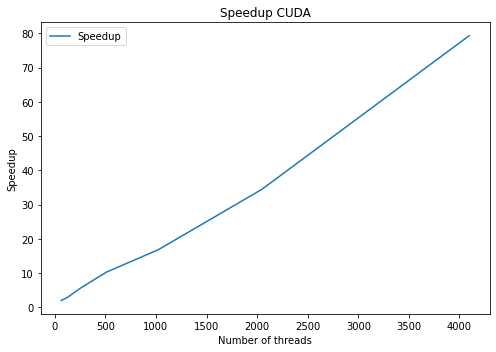

[(4096, 0.019364415827847148), (2048, 0.016837960856912523), (1024, 0.016455074055783673), (512, 0.020159301524353707), (256, 0.02213070465687006), (128, 0.02330620023970788), (64, 0.031368503852293346)]


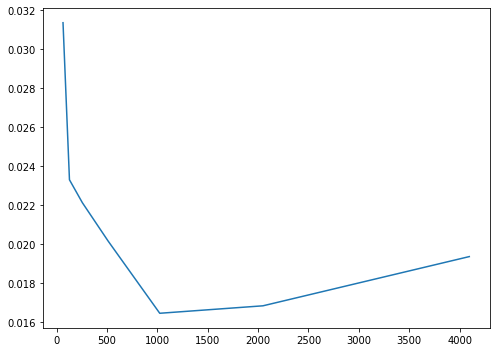

In [64]:
# Plot speedup cuda from file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

plt.rcParams["figure.figsize"] = [7.00, 5.0]
# plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

df_cuda = pd.read_csv("data/rules/cuda/time.txt", sep=",", header=None)
df_cuda.columns = ["Num threads", "time"]
df_cuda["speedup"] = df_opemmp["time"][0] / df_cuda["time"]
df_cuda["efficiency"] = df_cuda["speedup"] / df_cuda["Num threads"]
print([i for i in zip(df_cuda["Num threads"],df_cuda["speedup"])])
plt.plot(df_cuda["Num threads"], df_cuda["speedup"], label="Speedup")
plt.xlabel("Number of threads")
plt.ylabel("Speedup")
plt.title("Speedup CUDA")
plt.legend()
plt.show()
# save plot svg
plot_path = Path("docs/img/speedup_cuda.svg")
fig.savefig(plot_path, format="svg")


# Plot efficiency cuda from dataframe
print([i for i in zip(df_cuda["Num threads"],df_cuda["efficiency"])])
plt.plot(df_cuda["Num threads"], df_cuda["efficiency"], label="Efficiency")


[(1, 1.0), (2, 1.6719849982419814), (3, 2.42244933537705), (4, 3.394441712536286), (5, 4.228881186044765), (6, 4.732803998761446), (8, 5.898214733615764)]


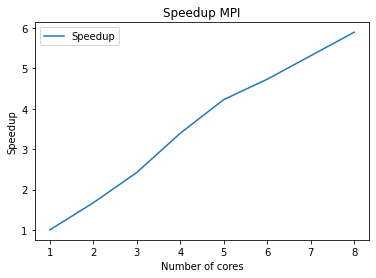

[(1, 1.0), (2, 0.8359924991209907), (3, 0.80748311179235), (4, 0.8486104281340715), (5, 0.845776237208953), (6, 0.7888006664602409), (8, 0.7372768417019705)]


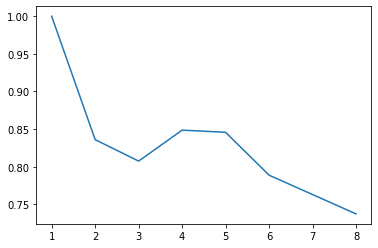

In [100]:
# Plot speedup mpi from file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_mpi = pd.read_csv("data/rules/mpi/time.txt", sep=",", header=None)
df_mpi.columns = ["Num cores", "time"]
df_mpi["speedup"] = df_mpi["time"][0] / df_mpi["time"]
print([i for i in zip(df_mpi["Num cores"],df_mpi["speedup"])])

plt.plot(df_mpi["Num cores"], df_mpi["speedup"], label="Speedup")
plt.xlabel("Number of cores")
plt.ylabel("Speedup")
plt.title("Speedup MPI")
plt.legend()
plt.show()

# Plot efficiency mpi from dataframe
df_mpi["efficiency"] = df_mpi["speedup"] / df_mpi["Num cores"]
print([i for i in zip(df_mpi["Num cores"],df_mpi["efficiency"])])
plt.plot(df_mpi["Num cores"], df_mpi["efficiency"], label="Efficiency")

/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


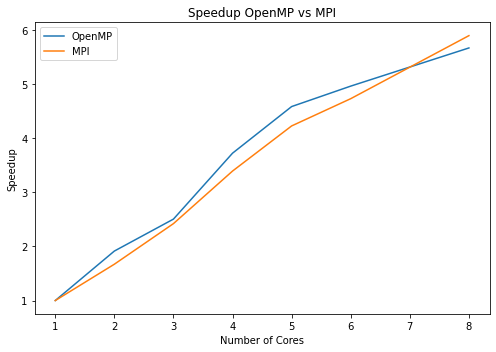

In [66]:
# Speed up openmp vs mpi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots()

df_opemmp= pd.read_csv("data/rules/openmp/time.txt", sep=",", header=None)
df_opemmp.columns = ["Num Cores", "time"]
df_opemmp["opemMP"] = df_opemmp["time"][0] / df_opemmp["time"]

df_mpi = pd.read_csv("data/rules/mpi/time.txt", sep=",", header=None)
df_mpi.columns = ["Num Cores", "time"]
df_mpi["MPI"] = df_mpi["time"][0] / df_mpi["time"]

df = pd.merge(df_opemmp, df_mpi, on="Num Cores")

plt.plot(df["Num Cores"], df["opemMP"], label="OpenMP")
plt.plot(df["Num Cores"], df["MPI"], label="MPI")
plt.xlabel("Number of Cores")
plt.ylabel("Speedup")
plt.title("Speedup OpenMP vs MPI")
plt.legend()
plt.show()

# Save plot svg
plot_path = Path("docs/img/speedup_openmp_vs_mpi.svg")
fig.savefig(plot_path)


In [11]:
# Load Glove model from zip file
from gensim.models  import  KeyedVectors

model = KeyedVectors.load_word2vec_format("glove-sbwc.i25.vec.gz", binary=False) 

In [54]:
model.similar_by_word("determinante")

[('decisivo', 0.6952821612358093),
 ('factor', 0.6559731364250183),
 ('relevante', 0.6212716698646545),
 ('fundamental', 0.6197479367256165),
 ('elemento', 0.6190568804740906),
 ('decisiva', 0.6174859404563904),
 ('crucial', 0.6125585436820984),
 ('esencial', 0.5681983232498169),
 ('clave', 0.563787579536438),
 ('importante', 0.5565439462661743)]

In [73]:
model.distance("expl", "brasil")

1.0907507613301277

In [ ]:
model.get_mean_vector((";",))

In [85]:
model.n_similarity(["punctuation"], ".".split())

0.0